<a href="https://colab.research.google.com/github/diyanigam/satelliteimagery/blob/main/satellite_imagery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

GPU Setup

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

GPU: []
Num GPUs: 0


**Loading Dataset**

In [ ]:
data = tfds.load('uc_merced', split='train')
data = tfds.as_numpy(data)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/uc_merced/2.0.0.incompleteF26T8X/uc_merced-train.tfrecord*...:   0%|      …

Dataset uc_merced downloaded and prepared to /root/tensorflow_datasets/uc_merced/2.0.0. Subsequent calls will reuse this data.


**Data Preprocessing**

In [ ]:
x,y = [], []
for i in data:
    img = tf.image.resize(i['image'], [256, 256])
    x.append(img)
    y.append(i['label'])

x = np.array(x)
y = np.array(y)

**Training-Testing Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# **CNN Model**

In [ ]:
model = models.Sequential([
    layers.Conv2D(64, (3, 3), strides=(1,1), activation='relu', padding='same', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), strides=(1,1), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2),strides=(2,2), padding='same'),
    layers.Dropout(0.25),
    layers.Conv2D(256, (3, 3), strides=(1,1), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2),strides=(2,2), padding='same'),
    layers.Conv2D(512, (3, 3), strides=(1,1), activation='relu', padding='same'),
    # layers.Conv2D(128, (3, 3), strides=(1,1), activation='relu', padding='same'),
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    # layers.Conv1D(128, 3, strides=), activation='relu', padding='same'),
    layers.Dense(21, activation='softmax')
])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001)
model.compile(optimizer = Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=2, epochs=200, verbose=1, validation_data=[X_val, y_val], callbacks=[early_stopping, reduce_lr])

Epoch 1/200
756/756 [==============================] - 24s 21ms/step - loss: 3.5964 - accuracy: 0.0529 - val_loss: 3.0399 - val_accuracy: 0.0417 - lr: 0.0010
Epoch 2/200
756/756 [==============================] - 16s 21ms/step - loss: 3.1230 - accuracy: 0.0569 - val_loss: 3.0422 - val_accuracy: 0.0893 - lr: 0.0010
Epoch 3/200
756/756 [==============================] - 16s 21ms/step - loss: 3.0680 - accuracy: 0.0747 - val_loss: 3.0661 - val_accuracy: 0.0357 - lr: 0.0010
Epoch 4/200
756/756 [==============================] - 15s 19ms/step - loss: 3.0097 - accuracy: 0.0761 - val_loss: 2.8749 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 5/200
756/756 [==============================] - 14s 19ms/step - loss: 2.9414 - accuracy: 0.1058 - val_loss: 2.8353 - val_accuracy: 0.0833 - lr: 0.0010
Epoch 6/200
756/756 [==============================] - 14s 19ms/step - loss: 2.6015 - accuracy: 0.1713 - val_loss: 2.3202 - val_accuracy: 0.2381 - lr: 0.0010
Epoch 7/200
756/756 [==============================]

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

14/14 [==============================] - 3s 81ms/step - loss: 1.0920 - accuracy: 0.7762
Test accuracy: 0.776190459728241


**Evaluation Graphs**

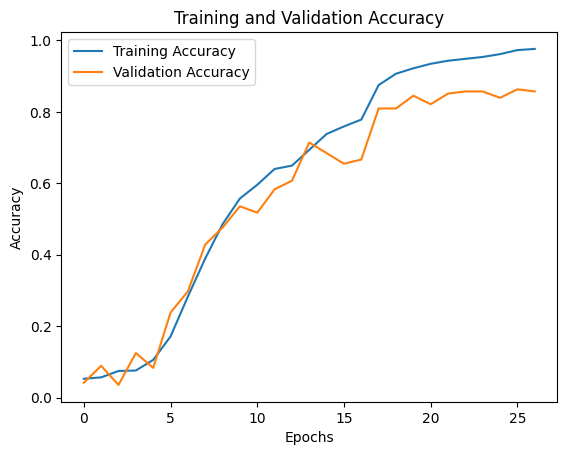

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

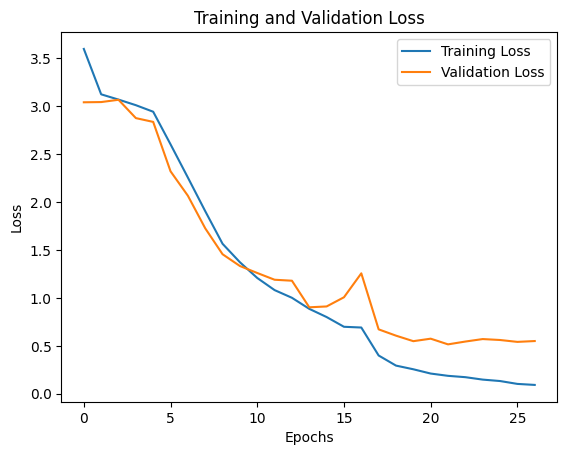

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

14/14 [==============================] - 1s 46ms/step - loss: 1.0920 - accuracy: 0.7762
Test accuracy: 0.776190459728241


Saving and Loading this Model

In [ ]:
model.save('my_model.keras')

In [ ]:
from keras.models import load_model

In [ ]:
new_model = load_model('my_model.keras')

In [ ]:
predictions = new_model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
for i in range(10):
    print(f'Predicted Label: {predicted_labels[i]}, True Label: {y_test[i]}')

1/1 [==============================] - 1s 994ms/step
Predicted Label: 7


Xception
VGG16
VGG19
ResNet50
ResNet101
ResNet152

# **ResNet 50**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

In [ ]:
resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(256,256,3))
for layer in resnet_50.layers:
    layer.trainable = False

In [ ]:
x = resnet_50.output
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
predictions = layers.Dense(21, activation='softmax')(x)
model = Model(inputs = resnet_50.input, outputs = predictions)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
model.compile(optimizer = Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=2, epochs=20, verbose=1, validation_data=[X_val, y_val], callbacks=[early_stopping, reduce_lr])

Epoch 1/20
756/756 [==============================] - 487s 631ms/step - loss: 1.4072 - accuracy: 0.6111 - val_loss: 0.6093 - val_accuracy: 0.8155 - lr: 0.0010
Epoch 2/20
756/756 [==============================] - 449s 594ms/step - loss: 0.4136 - accuracy: 0.8790 - val_loss: 0.8195 - val_accuracy: 0.7560 - lr: 0.0010
Epoch 3/20
756/756 [==============================] - 425s 562ms/step - loss: 0.1943 - accuracy: 0.9537 - val_loss: 0.4466 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 4/20
756/756 [==============================] - 480s 635ms/step - loss: 0.3331 - accuracy: 0.9239 - val_loss: 0.5766 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 5/20
756/756 [==============================] - 489s 647ms/step - loss: 0.2914 - accuracy: 0.9339 - val_loss: 0.4703 - val_accuracy: 0.8690 - lr: 0.0010
Epoch 6/20
756/756 [==============================] - 475s 628ms/step - loss: 0.0991 - accuracy: 0.9702 - val_loss: 0.2463 - val_accuracy: 0.9345 - lr: 1.0000e-04
Epoch 7/20
756/756 [======================

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

14/14 [==============================] - 118s 8s/step - loss: 0.3501 - accuracy: 0.9214
Test accuracy: 0.9214285612106323


**Evaluation Graphs**

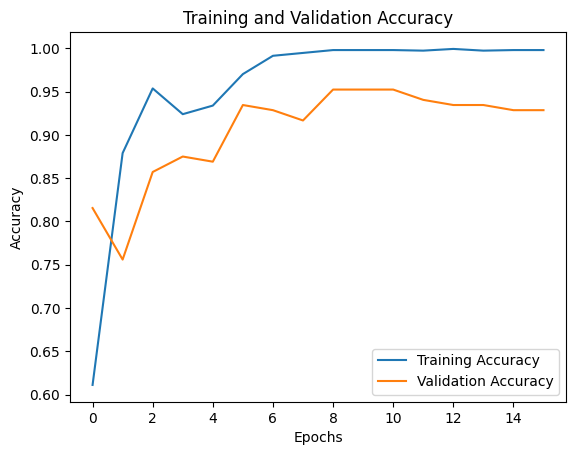

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

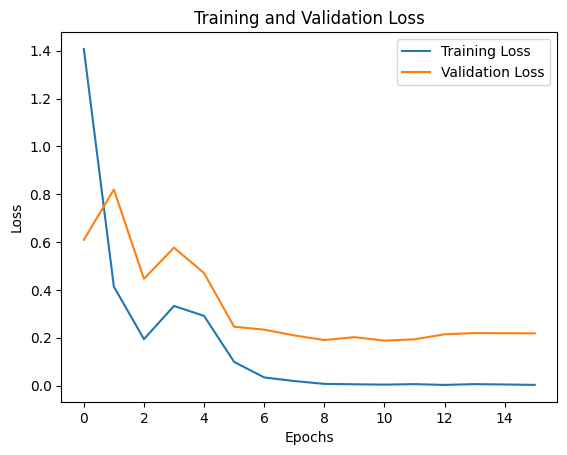

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# **ResNet101**

In [ ]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model

In [ ]:
resnet_101 = ResNet101(include_top=False, weights='imagenet', input_shape=(256,256,3))
for layer in resnet_101.layers:
    layer.trainable = False

171446536/171446536 [==============================] - 1s 0us/step


In [ ]:
x = resnet_101.output
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
predictions = layers.Dense(21, activation='softmax')(x)
model = Model(inputs = resnet_101.input, outputs = predictions)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001)
model.compile(optimizer = Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=24, epochs=20, verbose=1, validation_data=[X_val, y_val], callbacks=[early_stopping, reduce_lr])

Epoch 1/20
63/63 [==============================] - 737s 11s/step - loss: 1.8490 - accuracy: 0.4563 - val_loss: 0.6771 - val_accuracy: 0.7679 - lr: 0.0010
Epoch 2/20
63/63 [==============================] - 718s 11s/step - loss: 0.4216 - accuracy: 0.8538 - val_loss: 0.3875 - val_accuracy: 0.8631 - lr: 0.0010
Epoch 3/20
63/63 [==============================] - 726s 12s/step - loss: 0.1203 - accuracy: 0.9590 - val_loss: 0.2935 - val_accuracy: 0.9345 - lr: 0.0010
Epoch 4/20
63/63 [==============================] - 719s 11s/step - loss: 0.0562 - accuracy: 0.9808 - val_loss: 0.3123 - val_accuracy: 0.9107 - lr: 0.0010
Epoch 5/20
63/63 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.9709 

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

**Evaluation Graphs**

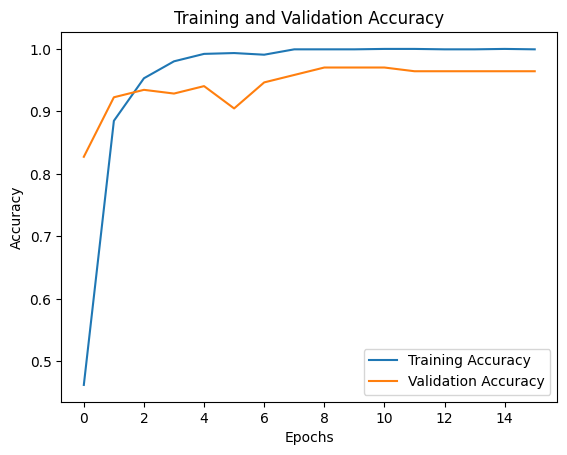

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

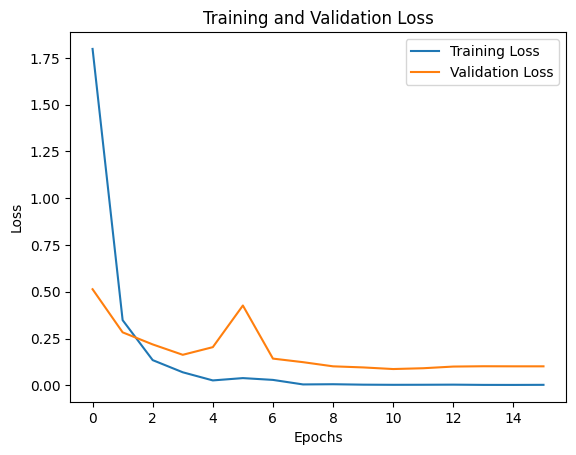

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# **Inception V3**

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model

In [ ]:
inception_v3 = InceptionV3(include_top=False, weights='imagenet', input_shape=(256,256,3))
for layer in inception_v3.layers:
    layer.trainable = False

In [ ]:
x = inception_v3.output
x = layers.Flatten()(x)
x = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
predictions = layers.Dense(21, activation='softmax')(x)
model = Model(inputs = inception_v3.input, outputs = predictions)

NameError: name 'inception_v3' is not defined

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.000001)
model.compile(optimizer = Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=10, epochs=200, verbose=1, validation_data=[X_val, y_val], callbacks=[early_stopping, reduce_lr])

NameError: name 'tf' is not defined

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

14/14 [==============================] - 1s 89ms/step - loss: 55.7471 - accuracy: 0.5429
Test accuracy: 0.5428571701049805


In [ ]:
x = inception_v3.output
x = layers.Dense(516, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Flatten()(x)
predictions = layers.Dense(21, activation='softmax')(x)
model = Model(inputs = inception_v3.input, outputs = predictions)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=22)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.000001)
model.compile(optimizer = Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=4, epochs=200, verbose=1, validation_data=[X_val, y_val], callbacks=[early_stopping, reduce_lr])

Epoch 1/200
378/378 [==============================] - 19s 29ms/step - loss: 896.9774 - accuracy: 0.0417 - val_loss: 3.0732 - val_accuracy: 0.0417 - lr: 0.1000
Epoch 2/200
378/378 [==============================] - 8s 22ms/step - loss: 10.1073 - accuracy: 0.0443 - val_loss: 3.0778 - val_accuracy: 0.0357 - lr: 0.1000
Epoch 3/200
378/378 [==============================] - 9s 23ms/step - loss: 3.1067 - accuracy: 0.0450 - val_loss: 3.1131 - val_accuracy: 0.0417 - lr: 0.1000
Epoch 4/200
378/378 [==============================] - 9s 24ms/step - loss: 3.1048 - accuracy: 0.0410 - val_loss: 3.0870 - val_accuracy: 0.0714 - lr: 0.1000
Epoch 5/200
378/378 [==============================] - 9s 24ms/step - loss: 3.0638 - accuracy: 0.0397 - val_loss: 3.0671 - val_accuracy: 0.0357 - lr: 0.0200
Epoch 6/200
378/378 [==============================] - 9s 24ms/step - loss: 3.0575 - accuracy: 0.0410 - val_loss: 3.0670 - val_accuracy: 0.0595 - lr: 0.0200
Epoch 7/200
378/378 [==============================] -

**Evaluation Graphs**

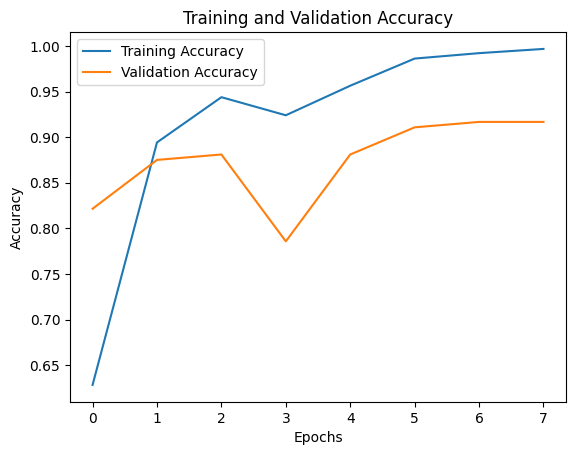

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

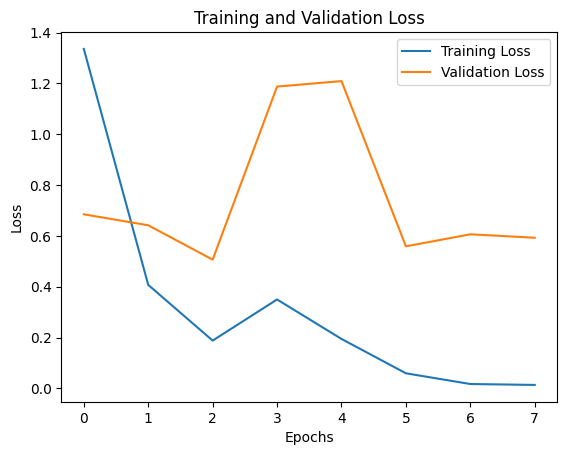

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# **VGG16**

In [ ]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


# **Xception**
input size of xception can only be 299x299 so plis dont change that (DEVESH)

**Data Preprocessing**

In [ ]:
x,y = [], []
for i in data:
    img = tf.image.resize(i['image'], [299, 299])
    x.append(img)
    y.append(i['label'])

x = np.array(x)
y = np.array(y)

**Training-Testing Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

xception = Xception(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
for layer in xception.layers:
    layer.trainable = False

In [ ]:
x = xception.output
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
predictions = Dense(21, activation='softmax')(x)
model = Model(inputs=xception.input, outputs=predictions)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
model.compile(optimizer = Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=2, epochs=20, verbose=1, validation_data=[X_val, y_val], callbacks=[early_stopping, reduce_lr])

Epoch 1/20
756/756 [==============================] - 92s 80ms/step - loss: 3.0549 - accuracy: 0.0529 - val_loss: 3.0334 - val_accuracy: 0.0952 - lr: 0.0010
Epoch 2/20
756/756 [==============================] - 58s 77ms/step - loss: 3.0204 - accuracy: 0.0734 - val_loss: 3.2581 - val_accuracy: 0.0893 - lr: 0.0010
Epoch 3/20
756/756 [==============================] - 57s 75ms/step - loss: 2.9668 - accuracy: 0.1111 - val_loss: 3.3873 - val_accuracy: 0.0655 - lr: 0.0010
Epoch 4/20
756/756 [==============================] - 56s 73ms/step - loss: 2.9870 - accuracy: 0.0933 - val_loss: 14.9856 - val_accuracy: 0.1429 - lr: 0.0010
Epoch 5/20
756/756 [==============================] - 56s 73ms/step - loss: 2.8490 - accuracy: 0.1455 - val_loss: 2.9070 - val_accuracy: 0.1131 - lr: 2.0000e-04
Epoch 6/20
756/756 [==============================] - 60s 80ms/step - loss: 2.7678 - accuracy: 0.1634 - val_loss: 3.4412 - val_accuracy: 0.1607 - lr: 2.0000e-04
Epoch 7/20
756/756 [=============================

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)